### Load Libraries

In [1]:
import sys
import numpy as np
import math
import random
import pandas as pd
from scipy.spatial import distance
from haversine import haversine
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xlwt
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum

### Define Classes

In [2]:
class health_center:
    """
    A class used to represent the health facilities
    Parameters
    ----------
    x : float the latitude location
    y : floatthe longitude of location
    ID : str a (preferrably unique) identifier of the health facility
    𝐴e : float  Current available employees-hour
    𝐴v : float  Available vehicles for outreach operations 
    𝐶e : Float  Employee cost per hour at facility     
    """
    def __init__(self,
                x,             
                y,
                ID,
                name,
                Ae = 192,
                Ce = 5, 
                Av = 1):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.ID = str(ID)
        self.ID = str(name)
        self.type = 'health_facility'
        self.Ae = float(Ae)
        self.Ce = float(Ce)
        self.Av = float(Av)
        
        self.closestNetworkNode = None

In [3]:
class outreach_center:
    """
    A class used to represent the outreach centers
    Parameters
    ----------
    lat : float
        the latitude location
    lon : float
        the longitude of location
    ID : str
        a (preferrably unique) identifier of the health facility
    𝐴𝐸 : float
        Current available employees-hour 
    𝐶e : Float 
        Employee cost per hour at facility     
    
    Other Attributes
    ----------

    """
    
    def __init__(self,
                x,             
                y,
                name,
                ID):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.ID = str(ID)
        self.NAME = str(name)
        self.type = 'outreach_center'
        
        self.closestNetworkNode = None

In [4]:
class population_center:
    """
    A class used to represent the outreach centers
    Parameters
    ----------
    lat : float
        the latitude location
    lon : float
        the longitude of location
    ID : str
        a  unique  identifier of the population set
    D : float
        total current population
    Other Attributes
    ----------
    """
    
    def __init__(self,
                x,             
                y,
                ID,
                name,
                D):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.ID = str(ID)
        self.name = str(name)
        self.type = 'Population sets'
        self.D = float (D)
        
        self.closestNetworkNode = None


### Retrieves the gambia Open street maps road network and store in a variable called g

In [7]:
####Retrives the gambia network
buffer_m = 500 # Retrieve the entire country network + a border of 500 meter
from_place = 'gambia' 
if from_place == None:
    
        g = ox.graph_from_bbox(
            ymax, ymin, xmax, xmin,
            network_type = 'drive',
            truncate_by_edge = True,
            clean_periphery = True
        )
        
else:
        
        g = ox.graph_from_place(
            from_place,
            network_type = 'drive',
            truncate_by_edge = True,
            clean_periphery = True,
            buffer_dist = buffer_m # meters
        )   

KeyboardInterrupt: 

In [8]:
len(g.nodes)

41993


### Define Functions

In [9]:
###Calculate a distance between two nodes (Euclidian or Haversine)
def calc_dist(orig,dest,mode='Euclidian'):
    """
    Calculates a Euclidian distance

    Parameters
    ----------
    orig : customer or depot object
        origin node
    dest : customer or depot object
        destination node
    mode : string
        type of distance metric to use (Euclidian or Haversine)

    Returns
    -------
    dist : float
        Distance between origin and destination node
    """
    if mode == 'Euclidian':
            dist =  math.sqrt((orig[0]-dest[0])**2+(orig[1]-dest[1])**2) 
    elif mode == 'Haversine':
        dist = haversine([orig[0],orig[1]],[dest[0],dest[1]])
    else:
        dist = None
        print("Undefined distance metric.")
    
    return dist

In [10]:
###Calculate the demand function 

def calc_demand_factor ( origin, dest, distances, minimum=1, maximum=5 ):
    alfa=0
    if distances[(origin,dest)] < minimum:
        alfa = 1
    elif distances[(origin,dest)] < maximum:
        alfa = maximum/(maximum-minimum) - (1/(maximum-minimum))*distances[(origin,dest)]
    else:
        alfa =0
    return alfa

In [11]:
def closestNode(nodes, v, invDict):
    """
    Returns the closest node (i.e., intersection) on an OSM road network graph to an arbitrary point in space.

    Parameters
    ----------
    nodes: array-like of node locations (tuples)
    v: point to test
    invDict: dictionary of node location to node ID
    """
    
    # Function that returns the location of the node that is closest to the point tested
    closest = min(nodes, key=lambda p: haversine([v[0],v[1]],[p[0],p[1]]))
    # based on that location, return the ID of the closest node
    return invDict[closest]

In [12]:
def projectDataOSM(point_data, graph, Save=False, filename=None):
    """
    Snaps point data (e.g., customers and their demand information) to an underlying road network represented by a graph.

    Parameters
    ----------
    point_data : pandas dataframe 
        data frame containing data that can be tied to geographical locations (e.g., customer demand)
    graph : graph object
        graph representation of the underlying road network (from Networkx or OSMnx)
    Save : boolean
        whether or not the point data and the corresponding closest road network nodes should be saved to a CSV file
        default: False
    filename : string
        filename to use in case Save is set to True
        default: None

    Returns
    -------
    Nothing
    """
    
    # Create dictionary that maps the (x,y) locations of nodes (keys) to the respective node IDs (values)
    network_nodes = {}
    for n in graph.nodes.keys():
        network_nodes[(graph.nodes[n]['y'],graph.nodes[n]['x'])] = n
        
    # Snap each point in the point data to its nearest road network node (intersection)
    # - Initialize an empty list that will have the closest network node
    nodes = []
    # - Initialize an empty list that will have the closest network Latitude
    y = []
    # - Initialize an empty list that will have the closest network Longitude
    x=[]
    # - Initialize an empty list that will have the distance betweeen road node and original node
    dist=[]
    # - Iterate through every row of the point data (i.e., every point)
    for index,row in tqdm(point_data.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        close_node_key = closestNode(network_nodes.keys(), (row.lat,row.lng), network_nodes)
        nodes.append(close_node_key)
        y.append(graph.nodes[close_node_key]['y'])
        x.append(graph.nodes[close_node_key]['x'])
        dist.append ( haversine([row.lat,row.lng],[graph.nodes[close_node_key]['y'],graph.nodes[close_node_key]['x']])         )
                       
    # - Add the list of closest road network nodes to the data frame containing the point data
    point_data['closest_nw_node'] = nodes
    point_data['y'] = y
    point_data['x'] = x
    point_data['dist'] = dist
    
    # Save point data including the nearest node information to a CSV file (optional)
    if Save==True:
        if filename == None:
            print('File name not specified.')
        else:
            point_data.to_csv(filename)

In [13]:
def mapDataOSM(demand_data, depot_data,g, snap_to_grid=True, route_data=None, route_colors='green', Plot=True, from_place=None, buffer_m=1500,):
    """
    Takes customer demand data and depot information (i.e., point data), snaps it to the underlying road network 
    and plots it on a map.
    Optionally also displays routes (i.e., sequences of road network arcs travelled on) on that same map.
    
    Parameters
    ----------
    demand_data : pandas data frame 
        Data frame containing all customer location specific demand data
    depot_data : pandas data frame
        Data frame containing all available depot locations
      g : networkx graph object
          since it takes a long time to retrieve the road network, this was changed to a input of the function
    snap_to_grid : boolean
        Whether or not the point data (demand_data and depot_data) still needs to be matched up with the closest
        nodes of the underlying road network.
        default: True
    
    route_data : list of lists of road network node IDs
        Route information to be plotted (if any)
        default: None
    route_colors : string
        TBD
        default: 'green'
    Plot : boolean
        Whether or not to plot the data on a map
        default: True
    from_place : string
        Name of a place (address, borough, city, etc.) to use to retrieve OSM road network instead of 
        bounding box of demand data
        default: None
    buffer_m : float
        Margin in meters around the extent of the bounding box / the place defined to retrieve the OSM 
        road network data
        degault: 1,500

    Returns
    -------
    g : networkx graph object
        TBD
    fig, ax : figure and axis objects
        required for plotting
    """
    
    
    # Get bounding box of customer locations and print its coordinates
    
    print('Bounding box of point data:')
    ymax = max(demand_data.lat.append(demand_data.lat))
    print(ymax,'y max')
    ymin = min(demand_data.lat.append(demand_data.lat))
    print(ymin,'y min')
    xmax = max(demand_data.lng.append(demand_data.lng))
    print(xmax,'x max')
    xmin = min(demand_data.lng.append(demand_data.lng))
    print(xmin,'x min')
    
    if from_place != None:
        print('Place name used instead to retrieve road network:')
        print(from_place)
        
 # Query OSMnx graph around extents of customer nodes    

### ----------- THIS PART OF THE CODE WAS MOVED FOR OUTSIDE THE FUNCTION, REDUCE RUN TIME----------------   

##    print('Retrieving road network data from OSM...')


    
    #    if from_place == None:
    
#        g = ox.graph_from_bbox(
 #           ymax, ymin, xmax, xmin,
 #           network_type = 'drive',
 #           truncate_by_edge = True,
 #           clean_periphery = True
 #       )
        
 #   else:
        
 #       g = ox.graph_from_place(
 #           from_place,
 #           network_type = 'drive',
 #           truncate_by_edge = True,
 #           clean_periphery = True,
 #           buffer_dist = buffer_m # meters
 #       )
    
##-----------------------------------------------------------------------------##
    
    # Snap each point to nearest node (intersection) on road network graph
###------ To reduce run time, snap the data points outside the function ### -------------   
    if snap_to_grid==True:
        print('Snapping point data to road network...')
        projectDataOSM(demand_data, g)
        projectDataOSM(depot_data, g)
    else:
        print('Assuming nodes already projected on OSM graph.')

#### --------------------------------------------------------------------------------------    
    # Plot on network   
    
    if Plot==True:
        print('Plotting data on map...')
        if route_data != None:
            
            fig, ax = ox.plot_graph_routes(g, 
                                           route_data, 
                                           fig_height=25, 
                                           node_size=2, 
                                           node_alpha=0.5,
                                           edge_linewidth=0.3, 
                                           route_alpha=0.3,
                                           route_color = route_colors,
                                           orig_dest_node_color = 'green',
                                           orig_dest_node_size = 4.0,
                                           route_linewidth = 2.5,
                                           dpi=300, 
                                           show=False, close=False)
            
        else:

            fig, ax = ox.plot_graph(g, fig_height=20, show=False, close=False, edge_alpha = 0.25, node_alpha = 0)
            
        

       # ax.scatter(demand_data.lng,
                       #demand_data.lat,
                       #alpha=0.5,
                       #s=20*demand_data.Births)
        
        ax.scatter(demand_data.lng,
           demand_data.lat,
           alpha=1.0,
           color='red',
           marker='s',
           s=1)
        
        ax.scatter(depot_data.lng,
           depot_data.lat,
           alpha=1.0,
           color='blue',
           marker='s',
           s=10)

        plt.show()
    
    return g, fig, ax

In [14]:
###Compute a pairwise distance matrix for a list of nodes..

def d_matrix(origins, destinations,g=None,max_dist = 100, mode='Euclidian',returnPaths=False):
    """
    Calculates a distance matrix

    Parameters
    ----------
    origins : dict of  depot object
    destinations : dict of  destination object
       
    mode : str
        type of distance to use (Euclidian, Haversine, or OSM)
        default value: Euclidian

    Returns
    -------
    dist_mat : dict 
        origin-destination matrix of distances
    """
    path_mat = None
    if mode == 'Euclidian' or mode == 'Haversine':
        
        dist_mat = dict(
            [((i,j),calc_dist(origins[i].loc,destinations[j].loc,mode)) 
             for i in tqdm(origins) for j in destinations if calc_dist(origins[i].loc,destinations[j].loc,mode) <max_dist]
            )
        path_mat = None
        
        return dist_mat
        
    elif mode == 'OSM':
        if g == None:
            dist_mat = {}
            print("Network information missing.")
        else:
            dist_mat = dict(
                [((i,j),nx.shortest_path_length(g, origins[i].closestNetworkNode, destinations[j].closestNetworkNode, weight='length')) 
                 for i in tqdm(origins) for j in destinations]
            )
            if returnPaths == True:
                path_mat = dict(
                    [((i,j),nx.shortest_path(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode)) 
                     for i in tqdm(origins) for j in destinations]
                )
            else:
                path_mat = None
            
            return dist_mat, path_mat  
    else: 
        dist_mat = {}
        path_mat = None
        print("Undefined distance metric.")
        
    return dist_mat, path_mat

### Load the data

In [15]:
# load Population data 
pop = pd.read_csv('population_2x2.csv')
print(str(len(pop))+'pppulation centers')
pop.head()

3952pppulation centers


,ID_master,Type,ID,Name,lat,lng,Population
0,6765,Outreach,6765_POP,6765_POP,13.437500,-16.687500,23132.84033
1,6229,Outreach,6229_POP,6229_POP,13.454167,-16.687500,23131.23975
2,7018,Outreach,7018_POP,7018_POP,13.429167,-16.662500,23131.00000
3,7020,Outreach,7020_POP,7020_POP,13.429167,-16.645833,23131.00000
4,6507,Outreach,6507_POP,6507_POP,13.445833,-16.662500,23129.40039


In [16]:
# load health_facilities data 
hc = pd.read_csv('Health facilities.csv')
print(str(len(hc))+' Health centers.')
hc.head()

80 Health centers.


,Id (from master),Type,ID,Name,lat,lng
0,84,Health center,84_HC,Jahally,13.544915,-14.968326
1,85,Health center,85_HC,Bansang RCH,13.445809,-14.666725
2,86,Health center,86_HC,Brikamaba,13.538153,-14.923909
3,87,Health center,87_HC,Kaur,13.707806,-15.330726
4,88,Health center,88_HC,Kuntaur,13.672036,-14.889870


In [17]:
oc = pd.read_csv('Outreach center 2x2.csv')
print(str(len(oc))+' Outreach centers')
oc.head()

3952 Outreach centers


,ID_master,Type,ID,Name,lat,lng
0,1,Outreach,6765_ORC,6765_ORC,13.437500,-16.687500
1,1,Outreach,6229_ORC,6229_ORC,13.454167,-16.687500
2,1,Outreach,7018_ORC,7018_ORC,13.429167,-16.662500
3,1,Outreach,7020_ORC,7020_ORC,13.429167,-16.645833
4,1,Outreach,6507_ORC,6507_ORC,13.445833,-16.662500


Load the mosques data frame

In [18]:
oc_mosques = pd.read_csv('Mosques_ID.csv')
oc_mosques

FileNotFoundError: [Errno 2] File Mosques_ID.csv does not exist: 'Mosques_ID.csv'

#### load outreach_centers dat 
oc_1 = pd.read_csv('Outreach center_1.csv')
print(str(len(oc_1))+' Outreach centers')
oc_1.head()



#### load outreach_centers dat 
oc_2 = pd.read_csv('Outreach center_2.csv')
print(str(len(oc_2))+' Outreach centers')
oc_2.head()


### Create the Objects

In [19]:
population= dict([
     (pop.ID.iloc[i],
     population_center(
              pop.lat.iloc[i],
              pop.lng.iloc[i],
              pop.ID.iloc[i],
              pop.Name.iloc[i],
              pop.Population.iloc[i]*1.002/12 )) for i in range(len(pop))
])

In [20]:
outreach_centers = dict([
    (oc.ID.iloc[i],
     outreach_center (
              oc.lat.iloc[i],
              oc.lng.iloc[i],
              oc.Name.iloc[i],
              oc.ID.iloc[i])) for i in range(len(oc))
])

outreach_centers_2 = dict([
    (oc_2.ID.iloc[i],
     outreach_center (
              oc_2.lat.iloc[i],
              oc_2.lng.iloc[i],
              oc_2.Name.iloc[i],
              oc_2.ID.iloc[i])) for i in range(len(oc_2))
])

outreach_centers_1 = dict([
    (oc_1.ID.iloc[i],
     outreach_center (
              oc_1.lat.iloc[i],
              oc_1.lng.iloc[i],
              oc_1.Name.iloc[i],
              oc_1.ID.iloc[i])) for i in range(len(oc_1))
])

In [21]:
health_centers = dict([
    (hc.ID.iloc[i],
     health_center (
              hc.lat.iloc[i],
              hc.lng.iloc[i],
              hc.ID.iloc[i],             
              hc.Name.iloc[i])) for i in range(len(hc))
])


outreach_centers = {**outreach_centers_1,**outreach_centers_2}

### Node projection in road network

In [22]:
###--- Proeject the read OC in the OSM network, fiding the closest network, be carefull takes 40 min to run-
##- Receives a data frame OC and the OSM graph and returns the data frame with closest network node latitude/longitude and its distance
projectDataOSM(oc, g, Save=False, filename=None)

3952it [10:25,  6.32it/s]


In [23]:
### Export the projected outreach centers to A CSV file
oc.to_csv('Outreach Centers with Road network point 2x2.csv')

In [24]:
oc.tail()

,ID_master,Type,ID,Name,lat,lng,closest_nw_node,y,x,dist
3947,1,Outreach,7517_ORC,7517_ORC,13.412500,-16.737500,2447492545,13.412263,-16.737462,0.026692
3948,1,Outreach,11060_ORC,11060_ORC,13.270833,-16.462500,7281061528,13.268684,-16.497995,3.848961
3949,1,Outreach,4706_ORC,4706_ORC,13.504167,-15.545833,1809757798,13.509481,-15.569203,2.594868
3950,1,Outreach,4702_ORC,4702_ORC,13.504167,-15.579167,1809757798,13.509481,-15.569203,1.228692
3951,1,Outreach,4969_ORC,4969_ORC,13.495833,-15.587500,1809757798,13.509481,-15.569203,2.493302


In [25]:
### Add to the outreach object the closest network node 
for index,row in (oc.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        outreach_centers[row.ID].closestNetworkNode =  (row.closest_nw_node)

In [26]:
###--- Proeject the read HC in the OSM network, fiding the closest network, be carefull takes 40 min to run--- 
projectDataOSM(hc, g, Save=False, filename=None)

80it [00:18,  4.43it/s]


In [27]:
### Export the projected outreach centers to A CSV file
hc.to_csv('Health Centers with Road network point.csv')

In [28]:
hc.head()

,Id (from master),Type,ID,Name,lat,lng,closest_nw_node,y,x,dist
0,84,Health center,84_HC,Jahally,13.544915,-14.968326,3571449966,13.546255,-14.969153,0.173801
1,85,Health center,85_HC,Bansang RCH,13.445809,-14.666725,358469404,13.445978,-14.665964,0.084455
2,86,Health center,86_HC,Brikamaba,13.538153,-14.923909,2076302712,13.538207,-14.924468,0.060698
3,87,Health center,87_HC,Kaur,13.707806,-15.330726,336239756,13.707075,-15.331108,0.091197
4,88,Health center,88_HC,Kuntaur,13.672036,-14.889870,2901410475,13.671018,-14.890883,0.157463


In [29]:
### Add to the health_center object the closest network node 
for index,row in (hc.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        health_centers[row.ID].closestNetworkNode =  (row.closest_nw_node)

### Filtering of candidate sites 

In [31]:
# the candidate site for outreacg will be a network node. If more than one point of the grid have as closest network node the same point
# only one point node shall be considered 
oc_filtered = pd.pivot_table(oc, values=['y','x'], index = 'closest_nw_node', aggfunc=[np.mean])
oc_filtered.columns = ['lng','lat', ]
oc_filtered = oc_filtered.reset_index()
oc_filtered['ID']= oc_filtered['closest_nw_node']
oc_filtered['Name']= oc_filtered['closest_nw_node']
oc_filtered

,closest_nw_node,lng,lat,ID,Name
0,22132318,-14.652506,13.437462,22132318,22132318
1,249167664,-16.230343,13.207665,249167664,249167664
2,249167677,-16.414869,13.179624,249167677,249167677
3,249168069,-16.014857,13.231652,249168069,249168069
4,249168093,-15.829864,13.296417,249168093,249168093
...,...,...,...,...,...
2353,7414981714,-14.791439,13.547928,7414981714,7414981714
2354,7414981862,-14.781284,13.580027,7414981862,7414981862
2355,7414981879,-14.780219,13.578229,7414981879,7414981879
2356,7415317374,-14.807525,13.573461,7415317374,7415317374


In [32]:
outreach_centers={}
outreach_centers

{}

In [33]:
outreach_centers = dict([
    (oc_filtered.ID.iloc[i],
     outreach_center (
              oc_filtered.lat.iloc[i],
              oc_filtered.lng.iloc[i],
              oc_filtered.Name.iloc[i],
              oc_filtered.ID.iloc[i])) for i in range(len(oc_filtered))
])

In [34]:
### Add to the outreach object the closest network node 
for index,row in (oc_filtered.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        outreach_centers[row.ID].closestNetworkNode =  (row.closest_nw_node)

#### Create dictionary with filtered objects

In [35]:
origins ={}
destination={}
nodes = {}
origins = {**outreach_centers,**health_centers}
destination = {**outreach_centers,**population}
nodes = {**population,**outreach_centers,**health_centers}
print ("origins, destination, total",len ( origins),len(destination),  len ( nodes))

origins, destination, total 2438 6310 6390


#### Distance - OSM ( takes 16 hours to run) - USE THIS CODE BLOCK IF YOU DON'T HAVE THE DISTANCES CALCULATED IN A CSV

In [33]:
#pre - process in super computer and read the matrix through a csv file ( takes so much because it solves 350 thousand SPP )
dist_f_o_OSM=  d_matrix(health_centers, outreach_centers,g,max_dist = 100, mode='OSM',returnPaths=False)

  0%|          | 0/80 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
dist_f_o_OSM  = dist_f_o_OSM[0]
type (dist_f_o_OSM)


NameError: name 'dist_f_o_OSM' is not defined

In [35]:
dist_f_o_OSM

NameError: name 'dist_f_o_OSM' is not defined

In [18]:
df_dist_f_o_OSM = pd.DataFrame(columns=['key', 'distance[Km]'])
df_dist_f_o_OSM

,key,distance[Km]


In [17]:
for key in dist_f_o_OSM:
    df_dist_f_o_OSM = df_dist_f_o_OSM.append({'key':  key ,'distance[m]': dist_f_o_OSM[key]} ,ignore_index = True)            

NameError: name 'dist_f_o_OSM' is not defined

In [79]:
df_dist_f_o_OSM.size()

TypeError: 'numpy.int32' object is not callable

In [76]:
df_dist_f_o_OSM.to_csv('OSM_road_network_distances.csv')


#### Distance - OSM READ - USE THIS CODE BLOCK IF YOU  HAVE THE DISTANCES ALREADY CALCULATED IN A CSV

In [36]:
## we are only reading the OD pairs that have a distance lower than 75 km - limit the size of the problem
df_dist_osm = pd.read_csv('OSM_road_network_distances_full_2x2_les35000.CSV') 
print(str(len(df_dist_osm))+' df_dist_osm')
df_dist_osm.head()


169573 df_dist_osm


,key,distance,Keep
0,"('370_HC', 6191830028)",350035.621,6191830028
1,"('636_HC', 7176378649)",350033.164,7176378649
2,"('276_HC', 6359503948)",350030.227,6359503948
3,"('316_HC', 4710205561)",350028.457,4710205561
4,"('276_HC', 2612113392)",350026.081,2612113392


In [37]:
dist_f_o_OSM= dict([
    (eval(df_dist_osm.key.iloc[i]) ,df_dist_osm.distance.iloc[i]) for i in range(len(df_dist_osm)) ])

In [38]:
len (dist_f_o_OSM)

169573

### Pre processing - Decifding which Outreach centers to kepp

In [39]:
oc['dist'].describe()

count    3952.000000
mean        1.523950
std         1.341611
min         0.002870
25%         0.543456
50%         1.160800
75%         2.109539
max         8.377864
Name: dist, dtype: float64

In [154]:
##distance greater than 5 km
oc['dist'][oc['dist']<2].count()

2859

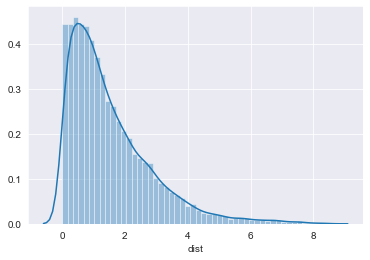

In [300]:
###histogram
sns.set_style('darkgrid')
sns.distplot (oc['dist'], )

In [301]:
pop.head()

,ID_master,Type,ID,Name,lat,lng,Sum of Pop in catchment area,Births,Pop/km2
0,1,Outreach,1_ORC,1_ORC,13.820833,-15.079167,74.097801,74.097801,74.097801
1,2,Outreach,2_ORC,2_ORC,13.820833,-15.070833,74.130096,74.130096,74.130096
2,3,Outreach,3_ORC,3_ORC,13.820833,-15.062500,72.328300,72.328300,72.328300
3,4,Outreach,4_ORC,4_ORC,13.820833,-15.054167,64.288803,64.288803,64.288803
4,5,Outreach,5_ORC,5_ORC,13.820833,-15.045833,51.213798,51.213798,51.213798


In [302]:
pop['Pop/km2']= pop['Births']

In [303]:
pop['Pop/km2'][ [pop['Pop/km2']>500] 

SyntaxError: unexpected EOF while parsing (<ipython-input-303-0ad26eeea119>, line 1)

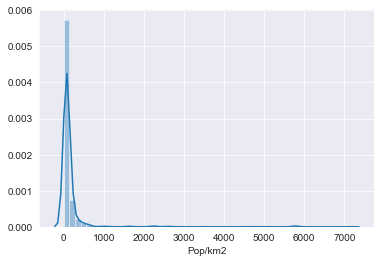

In [304]:
sns.distplot (pop['Pop/km2'], kde =True)

In [305]:
pop['Pop/km2'].describe()

count    12796.000000
mean       160.747020
std        490.057501
min          0.001783
25%         52.495602
50%         77.777298
75%        114.444000
max       7146.680176
Name: Pop/km2, dtype: float64

In [306]:
pop['Pop/km2'][pop['Pop/km2']>500].count()

453

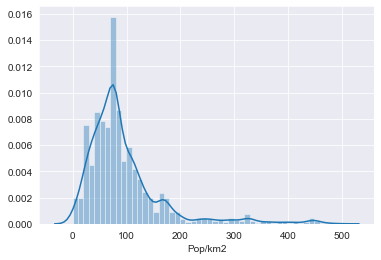

In [307]:
sns.distplot (pop['Pop/km2'][pop['Pop/km2']<500], kde =True)

In [308]:
pop['Pop/km2'].describe()

count    12796.000000
mean       160.747020
std        490.057501
min          0.001783
25%         52.495602
50%         77.777298
75%        114.444000
max       7146.680176
Name: Pop/km2, dtype: float64

In [309]:
oc_pop  = pd.merge(oc,pop,on='ID_master')
oc_pop.head()

,ID_master,Type_x,ID_x,Name_x,lat_x,lng_x,Unnamed: 6,closest_nw_node,y,x,dist,Type_y,ID_y,Name_y,lat_y,lng_y,Sum of Pop in catchment area,Births,Pop/km2
0,1,Outreach,1_ORC,1_ORC,13.820833,-15.079167,NaN,3739927481,13.795537,-15.070895,2.951219,Outreach,1_ORC,1_ORC,13.820833,-15.079167,74.097801,74.097801,74.097801
1,2,Outreach,2_ORC,2_ORC,13.820833,-15.070833,NaN,3739927481,13.795537,-15.070895,2.812813,Outreach,2_ORC,2_ORC,13.820833,-15.070833,74.130096,74.130096,74.130096
2,3,Outreach,3_ORC,3_ORC,13.820833,-15.062500,NaN,3739927481,13.795537,-15.070895,2.955264,Outreach,3_ORC,3_ORC,13.820833,-15.062500,72.328300,72.328300,72.328300
3,4,Outreach,4_ORC,4_ORC,13.820833,-15.054167,NaN,4337224789,13.796852,-15.050114,2.702301,Outreach,4_ORC,4_ORC,13.820833,-15.054167,64.288803,64.288803,64.288803
4,5,Outreach,5_ORC,5_ORC,13.820833,-15.045833,NaN,4337224789,13.796852,-15.050114,2.706412,Outreach,5_ORC,5_ORC,13.820833,-15.045833,51.213798,51.213798,51.213798


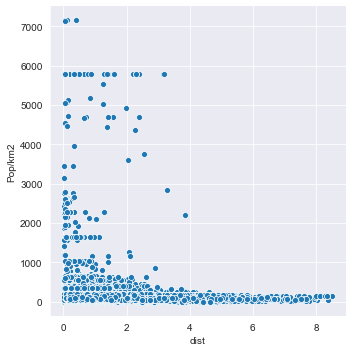

In [310]:
sns.relplot(x='dist',y='Pop/km2',data=oc_pop)

692


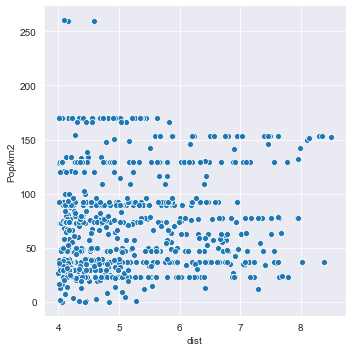

In [311]:

sns.relplot(x='dist',y='Pop/km2',data=oc_pop[oc_pop['dist']>4])
print (oc_pop['dist'][oc_pop['dist']>4].count())

In [213]:
filter_less_4km = oc_pop['dist'] <4

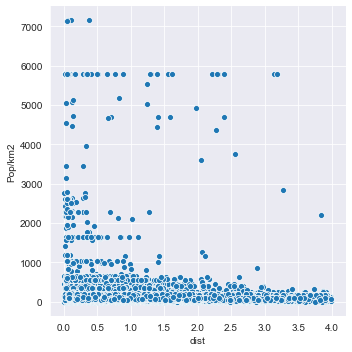

In [214]:
filter_less_4km = oc_pop['dist'] <4
filte_pop_thirdq  = oc_pop['Pop/km2'] >114
sns.relplot(x='dist',y='Pop/km2',data=oc_pop[filter_less_4km])

In [215]:
oc_filtered_less_4km = oc[filter_less_4km][filte_pop_thirdq]
oc_filtered_less_4km

C:\Users\carretti\Anaconda3\envs\OSMNX\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ID_master,Type,ID,Name,lat,lng,Unnamed: 6,closest_nw_node,y,x,dist
54,55,Outreach,55_ORC,55_ORC,13.795833,-14.937500,NaN,3739470694,13.801337,-14.946855,1.181155
55,56,Outreach,56_ORC,56_ORC,13.795833,-14.929167,NaN,3954801656,13.783687,-14.939908,1.780338
83,84,Outreach,84_ORC,84_ORC,13.787500,-14.945833,NaN,2332998633,13.782399,-14.942420,0.676492
84,85,Outreach,85_ORC,85_ORC,13.787500,-14.937500,NaN,3954801656,13.783687,-14.939908,0.497370
85,86,Outreach,86_ORC,86_ORC,13.787500,-14.929167,NaN,4249948095,13.782094,-14.938730,1.194907
...,...,...,...,...,...,...,...,...,...,...,...
12787,12788,Outreach,12788_ORC,12788_ORC,13.087500,-16.754167,NaN,2586869932,13.087702,-16.754177,0.022522
12788,12789,Outreach,12789_ORC,12789_ORC,13.087500,-16.745833,NaN,6395837278,13.088439,-16.748357,0.292590
12790,12791,Outreach,12791_ORC,12791_ORC,13.079167,-16.770833,NaN,6393455404,13.078841,-16.770716,0.038410
12791,12792,Outreach,12792_ORC,12792_ORC,13.079167,-16.762500,NaN,6393455404,13.078841,-16.770716,0.890585


### Nodes visualitzation

In [40]:
# Project the full grid
# (with a safety buffer of 500 meters around Gambia) and plot it
myg, fig, ax = mapDataOSM(oc,hc,g, snap_to_grid=False, from_place = 'Gambia', buffer_m=500)

Bounding box of point data:
13.82083333 y max
13.07083333 y min
-13.79583333 x max
-16.80416667 x min
Place name used instead to retrieve road network:
Gambia
Assuming nodes already projected on OSM graph.
Plotting data on map...


KeyboardInterrupt: 

In [ ]:
# just project outreach with : Population > 500
filte_pop_500  = oc_pop['Pop/km2'] >500
oc_filtered_500 = oc[filte_pop_500 ]
myg, fig, ax = mapDataOSM(pop,oc_filtered_500,g, snap_to_grid=False, from_place = 'Gambia', buffer_m=500)

In [ ]:
# just project outreach with : Population > 150 and distance < 4km 
filte_pop_114 = oc_pop['Pop/km2'] >114
oc_filtered_114 = oc[filte_pop_114 ]
myg, fig, ax = mapDataOSM(pop,oc_filtered_114,g, snap_to_grid=False, from_place = 'Gambia', buffer_m=500)

In [ ]:
# just project outreach with : Population > 150 and distance < 4km 
myg, fig, ax = mapDataOSM(oc_filtered_114,hc,g, snap_to_grid=False, from_place = 'Gambia', buffer_m=500)

In [ ]:
# just project outreach distance > 4km 
filte_dist_great_4 = oc_pop['dist'] >4
oc_filtered_great_4= oc[filte_dist_great_4 ]
myg, fig, ax = mapDataOSM(pop,oc_filtered_great_4,g, snap_to_grid=False, from_place = 'Gambia', buffer_m=500)

In [ ]:
filte_pop_med  = oc_pop['Pop/km2'] >77
oc_filtered_2 = oc[filter_less_4km][filte_pop_med]
myg, fig, ax = mapDataOSM(pop,oc_filtered_2,g, snap_to_grid=False, from_place = 'Gambia', buffer_m=500)

#### Outreach selection - Road network


Bounding box of point data:
13.82083333 y max
13.07083333 y min
-13.79583333 x max
-16.80416667 x min
Place name used instead to retrieve road network:
Gambia
Assuming nodes already projected on OSM graph.
Plotting data on map...


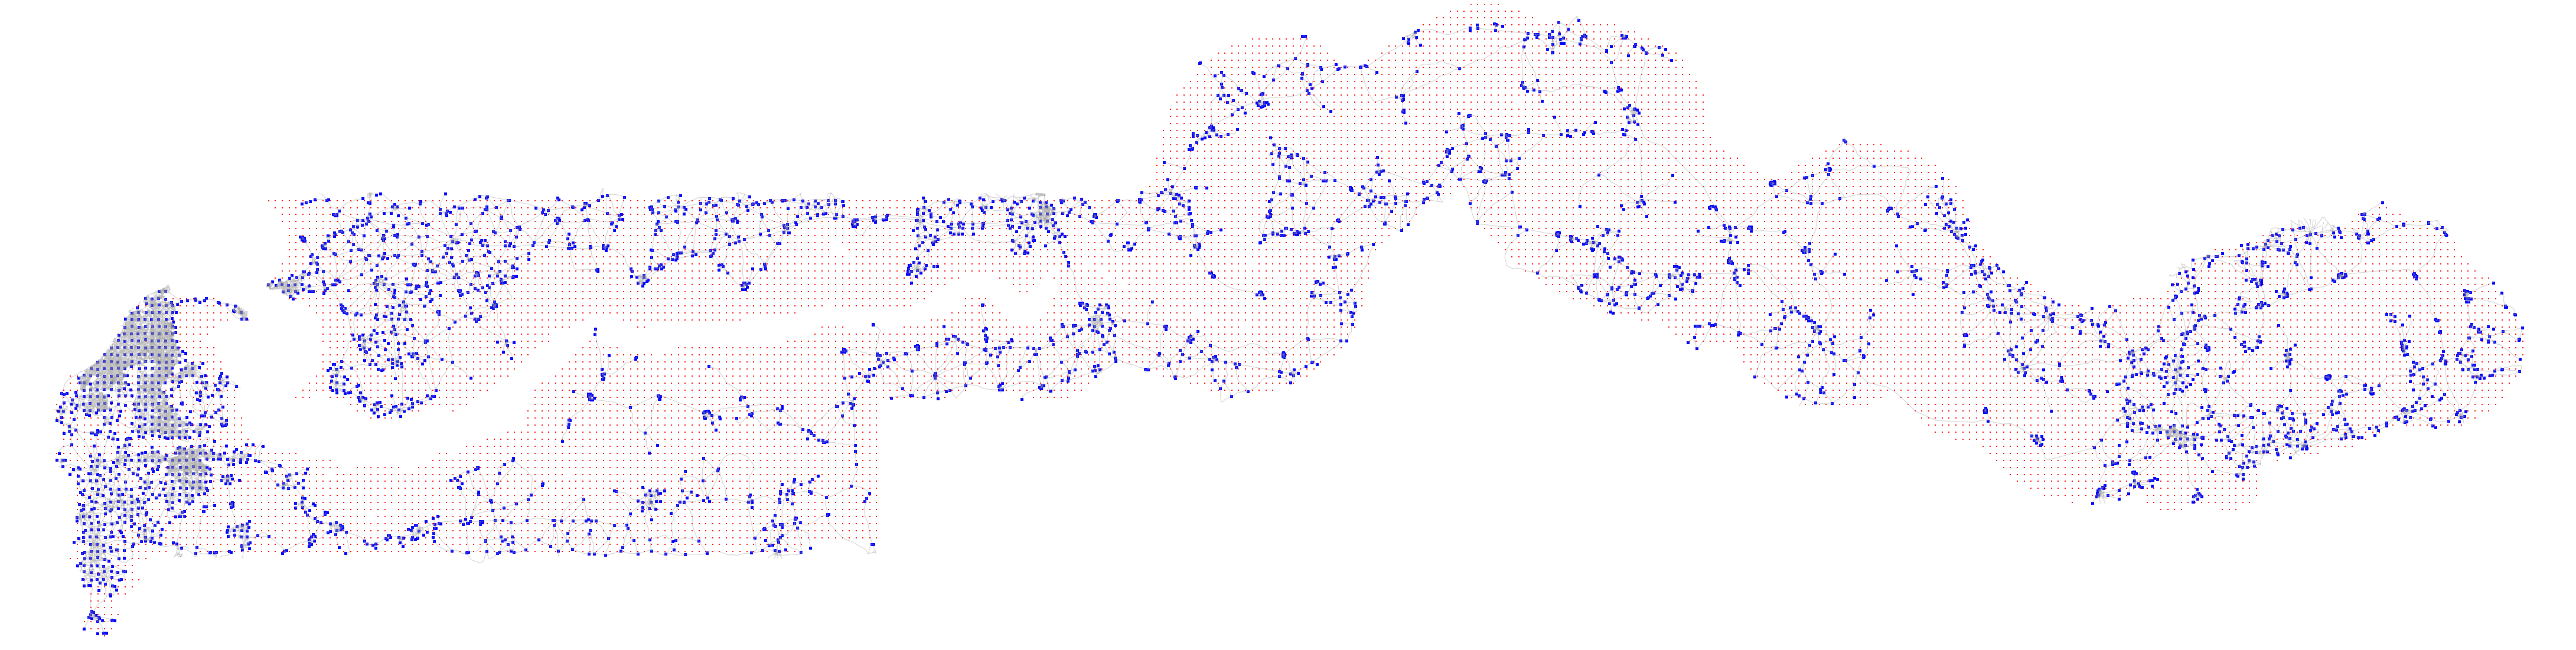

In [217]:
myg, fig, ax = mapDataOSM(pop,oc_filtered,g, snap_to_grid=False, from_place = 'Gambia', buffer_m=500)

In [218]:
pop.head()

,ID_master,Type,ID,Name,lat,lng,Sum of Pop in catchment area,Births,Pop/km2
0,1,Outreach,1_ORC,1_ORC,13.820833,-15.079167,74.097801,74.097801,74.097801
1,2,Outreach,2_ORC,2_ORC,13.820833,-15.070833,74.130096,74.130096,74.130096
2,3,Outreach,3_ORC,3_ORC,13.820833,-15.062500,72.328300,72.328300,72.328300
3,4,Outreach,4_ORC,4_ORC,13.820833,-15.054167,64.288803,64.288803,64.288803
4,5,Outreach,5_ORC,5_ORC,13.820833,-15.045833,51.213798,51.213798,51.213798


### Calculate Distance

In [41]:
dist_o_j = {}
dist_o_j= d_matrix(outreach_centers, population,max_dist = 10,returnPaths=True,mode='Haversine')

100%|██████████| 2358/2358 [00:48<00:00, 48.26it/s]


In [42]:
dist_f_j= d_matrix(health_centers, population,max_dist = 10,returnPaths=True,mode='Haversine')

100%|██████████| 80/80 [00:01<00:00, 71.42it/s]


In [43]:
len(dist_f_j) 

6729

dist_f_o=d_matrix(health_centers, outreach_centers,max_dist = 40,returnPaths=True,mode='Haversine')

In [44]:
len(dist_f_o_OSM)

169573

In [45]:
distances = {**dist_o_j,**dist_f_j,**dist_f_o_OSM }

In [46]:
print (len(distances), type(distances)) 

390986 <class 'dict'>


### Demand of archs

In [47]:
### calculates the demand matrix to all the customers assuming the decrease in coverage due to increase in distance given in function calc_demand_factor
demand_mat = dict(
    [((i,j), calc_demand_factor (i,j,distances,2,10) * population[j].D )
             for i in origins for j in population if (i,j) in distances ]) 

demand_mat

{(22132318, '7409_POP'): 142.55339041157129,
 (22132318, '6902_POP'): 153.07545891091138,
 (22132318, '7152_POP'): 103.32296119275864,
 (22132318, '7156_POP'): 139.35946558734767,
 (22132318, '7674_POP'): 41.11288943587727,
 (22132318, '7678_POP'): 71.89641652690904,
 (22132318, '6652_POP'): 47.259945395658946,
 (22132318, '7950_POP'): 34.41813596049295,
 (22132318, '6394_POP'): 39.59363331289671,
 (22132318, '8768_POP'): 9.05112490225846,
 (22132318, '8235_POP'): 16.331845074766182,
 (22132318, '8766_POP'): 14.443497272211323,
 (22132318, '8233_POP'): 22.95830023901367,
 (22132318, '8239_POP'): 0.14618628471815445,
 (22132318, '8504_POP'): 5.623631463601566,
 (22132318, '7962_POP'): 11.117352351763536,
 (22132318, '7686_POP'): 22.08720426332125,
 (22132318, '7684_POP'): 30.26043802946017,
 (22132318, '7690_POP'): 4.009399084141909,
 (22132318, '7164_POP'): 25.390054570684793,
 (22132318, '7421_POP'): 14.77645632388938,
 (22132318, '7162_POP'): 34.920480532786485,
 (22132318, '7168_POP

### Creation of subsets for model test

In [50]:
### creates the subset of population centers
population_teste_id= ['1_Pop','4_Pop','8_Pop','15_Pop','25_Pop','326_Pop','85_Pop','86_Pop']
population_teste = {}
for i in population:
    ##if i in population_teste_id:
       ## print (i)
        population_teste[i]=population[i]


In [51]:
type(population_teste)

dict

In [52]:
### creates the subset of outreach centers
outreach_centers_id= ['1_ORC','4_ORC','8_ORC','15_ORC','25_ORC','326_ORC']
outreach_centers_teste={}
for j in outreach_centers:
   ## if j in outreach_centers_teste_id:
        outreach_centers_teste[j]=outreach_centers[j]

In [53]:
### creates the subset of health centers
health_centers_teste_id= ['85_HC','86_HC']
health_centers_teste = {}
for j in health_centers:
   ## if j in health_centers_teste_id:
        health_centers_teste[j]=health_centers[j]

In [54]:
print(len(health_centers_teste),
      len(outreach_centers_teste), 
      len(population_teste)
)

80 2358 3952


### Input variables

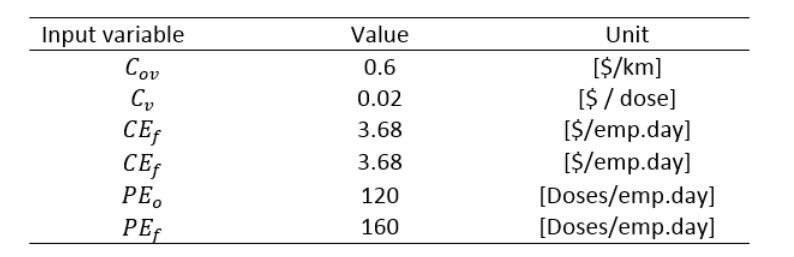

In [55]:
Budget = 12000
CEo = 3.68
### Cost per bundle 
COv = 0.6   #($/km)
### Cost to vaccinate in fixed facility (Vaccine Cost + Direct labor cost  ) 
Cfj = 0.02 + 3.68/160
### Cost to vaccinate in outreach center ( Vaccine Cost + Direct labor cost ) 
Coj = 0.02 + 3.68/120 

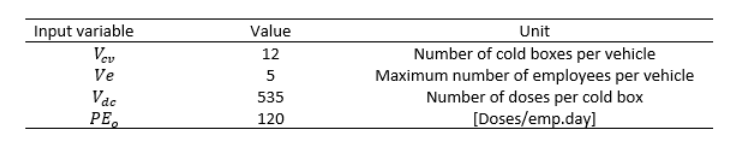

In [56]:
Vcv = 12 
Vdc = 535 
Ve = 5 
PEo = 120 ## 

In [57]:
m = gp.Model('Final model V1')
m.reset()
m.update()

Using license file C:\Users\carretti\gurobi.lic
Academic license - for non-commercial use only
Discarded solution information


### Add Decision variables

In [58]:
Xoj = dict(
    [((o,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="Xoj_%s_%s" %(o,j))) 
     for o in outreach_centers_teste 
     for j in population_teste if (o,j)in dist_o_j ]
)
len (Xoj)

214684

In [59]:
Xfo = dict(
    [((f,o), m.addVar(vtype=GRB.INTEGER, lb=0.0, name="Xfo_%s_%s" %(f,o))) 
     for f in health_centers_teste 
     for o in outreach_centers_teste if (f,o)in dist_f_o_OSM ]
)
len (Xfo)

166382

In [60]:
Xfj = dict(
    [((f,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="Xfj_%s_%s" %(f,j))) 
     for f in health_centers_teste 
     for j in population_teste if (f,j)in dist_f_j ]
)
len (Xfj)

6729

In [61]:
Yfj = dict(
    [((f,j), m.addVar(vtype=GRB.BINARY, lb=0.0, name="Yfj_%s_%s" %(f,j))) 
     for f in health_centers_teste 
     for j in population_teste if (f,j)in dist_f_j  ]
)
len (Xfj)

6729

In [62]:
Yoj = dict(
    [((o,j), m.addVar(vtype=GRB.BINARY, lb=0.0, name="Yoj_%s_%s" %(o,j))) 
     for o in outreach_centers_teste 
     for j in population_teste if (o,j)in dist_o_j  ]
)
len (Xoj)

214684

### Set Optimization Objective

In [63]:
m.setObjective(
    quicksum([Xoj[(o,j)] 
              for o in outreach_centers_teste 
              for j in population_teste if (o,j)in dist_o_j ])
     +quicksum([Xfj[(f,j)] 
              for f in health_centers_teste 
              for j in population_teste if (f,j)in dist_f_j ])
   ,
              GRB.MAXIMIZE)

### Add Constraints

###(1) Demand constraint for outreaches
C_01= dict(
    [((f,j),m.addConstr( Xfj[(f,j)]
                                >= 
                        demand_mat[(f,j)]*Yfj[(f,j)]
                     ,                "Health_facility_demand_arch_%s_%s"%(f,j)) )
     for f in health_centers_teste 
     for j in population_teste if (f,j)in dist_f_j]

C_02= dict(
    [((o,j),m.addConstr( Xoj[(o,j)]
                                >= 
                    demand_mat[(o,j)]*Yoj[(o,j)]
                     ,                "Outreach_demand_arch_%s_%s"%(o,j)) )
     for o in outreach_centers_teste 
     for j in population_teste if (o,j)in dist_o_j ]
)


C_000= dict(
    [((o,j),m.addConstr( quicksum(Yoj[(o,j)]
                                 for o in outreach_centers_teste if (o,j)in dist_o_j) +  
                        quicksum(Yfj[(f,j)]
                                 for f in health_centers_teste if (f,j)in dist_f_j) 
                                ==  
                      1
                     ,                "Outreach_demand_arch_%s_%s"%(o,j)) )
     
     for j in population_teste ]
)

In [64]:
###(1) Demand constraint for outreaches
C_1= dict(
    [((f,j),m.addConstr( Xfj[(f,j)]
                                <= 
                        demand_mat[(f,j)]*Yfj[(f,j)]
                     ,                "Health_facility_demand_arch_%s_%s"%(f,j)) )
     for f in health_centers_teste 
     for j in population_teste if (f,j)in dist_f_j]
)

In [65]:
###(2) Demand constraint for outreaches
C_2= dict(
    [((o,j),m.addConstr( Xoj[(o,j)]
                                <= 
                    demand_mat[(o,j)]*Yoj[(o,j)]
                     ,                "Outreach_demand_arch_%s_%s"%(o,j)) )
     for o in outreach_centers_teste 
     for j in population_teste if (o,j)in dist_o_j ]
)

In [66]:
###(7) guarantees that each region is serviced by one, and only one, facility 
C_7 = dict(
    [((j),m.addConstr( quicksum(Yfj[(f,j)]  for f in health_centers_teste if (f,j)in dist_f_j)+
                       quicksum(Yoj[(o,j)]  for o in outreach_centers_teste if (o,j)in dist_o_j) 
                       <=
                       1
                      ,
    "single_service%s" %(j)))
     for j in population_teste]
)

In [67]:
###(13) Flow conservation - Guarantee that cold box avaialability is respected
C_13 = dict(
    [((j),m.addConstr( quicksum(Xfo[(f,o)]* Vcv * Vdc  for f in health_centers_teste if (f,o)in dist_f_o_OSM ) 
                       >=
                       quicksum(Xoj[(o,j)]  for j in population_teste if (o,j)in dist_o_j)
                      ,
    "flow_conservation%s" %(j)))
     for o in outreach_centers_teste]
)

In [68]:
###(13) Flow conservation - Guarantee that human resource availability is respected
C_14 = dict(
    [((j),m.addConstr( quicksum(Xfo[(f,o)]* Ve * PEo  for f in health_centers_teste if (f,o)in dist_f_o_OSM ) 
                       >=
                       quicksum(Xoj[(o,j)]  for j in population_teste if (o,j)in dist_o_j)
                      ,
    "flow_conservation%s" %(j)))
     for o in outreach_centers_teste]
)

In [69]:
###(14) Budget 
C_15 = dict(
    [('budget',m.addConstr( 
                        quicksum (Xfo[(f,o)]* ( COv * dist_f_o_OSM[(f,o)]/1000 +CEo)
                        for f in health_centers_teste
                        for o in outreach_centers_teste
                        if (f,o)in dist_f_o_OSM)
        +
                        quicksum (Xfj[(f,j)]*Cfj   
                        for f in health_centers_teste
                        for j in population_teste
                        if (f,j)in dist_f_j)   
        +    
                        quicksum (Xoj[(o,j)]*Coj   
                        for o in outreach_centers_teste
                        for j in population_teste
                        if (o,j)in dist_o_j) 
        
                       <=
                       Budget                  ,
    "budget is respected") )
    ]
)

In [70]:
# Set model parameters
m.Params.timelimit = 12000.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.001         # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Changed value of parameter timelimit to 12000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.001
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 230082 rows, 609208 columns and 1814166 nonzeros
Model fingerprint: 0x4d95e388
Variable types: 221413 continuous, 387795 integer (221413 binary)
Coefficient statistics:
  Matrix range     [2e-05, 6e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 13819 rows and 183169 columns (presolve time = 5s) ...
Presolve removed 13819 rows and 183169 columns
Presolve time: 6.03s
Presolved: 216263 rows, 426039 columns, 1070990 nonzeros
Variable types: 213850 continuous, 212189 integer (210144 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iter

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\carretti\Anaconda3\envs\OSMNX\lib\site-packages\ipykernel\iostream.py", line 385, in write
    if self.echo is not None:
KeyboardInterrupt


     0     0 166891.092    0 6949 164969.802 166891.092  1.16%     -  744s
     0     0 166890.456    0 6861 164969.802 166890.456  1.16%     -  757s
     0     0 166890.216    0 6892 164969.802 166890.216  1.16%     -  762s
     0     0 166890.135    0 6816 164969.802 166890.135  1.16%     -  766s
     0     0 166882.334    0 7198 164969.802 166882.334  1.16%     -  786s
H    0     0                    165391.24138 166882.334  0.90%     -  859s
H    0     0                    166358.76848 166882.334  0.31%     -  931s
     0     0 166879.751    0 6721 166358.768 166879.751  0.31%     -  943s
     0     0 166878.891    0 7226 166358.768 166878.891  0.31%     -  950s
     0     0 166878.559    0 6986 166358.768 166878.559  0.31%     -  955s
     0     0 166878.481    0 7012 166358.768 166878.481  0.31%     -  958s
     0     0 166872.690    0 6290 166358.768 166872.690  0.31%     -  971s
     0     0 166871.185    0 6535 166358.768 166871.185  0.31%     -  988s
     0     0 166870.674  

In [358]:
m.printAttr('X')


    Variable            X 
-------------------------
Xoj_249168069_11112_POP      20.9844 
Xoj_249168069_11421_POP       23.092 
Xoj_249168069_11417_POP      20.1629 
Xoj_249168069_11419_POP      23.0112 
Xoj_249168069_11110_POP      17.4912 
Xoj_249168069_11723_POP       22.989 
Xoj_249168069_11114_POP      11.8338 
Xoj_249168069_11108_POP       15.109 
Xoj_249168069_11725_POP      22.3188 
Xoj_249168069_12247_POP      18.2682 
Xoj_249168069_12483_POP      13.4648 
Xoj_249168069_11423_POP      14.1957 
Xoj_249168069_11427_POP      6.59054 
Xoj_249168069_11429_POP      2.79757 
Xoj_249168069_12006_POP      16.6771 
Xoj_249168069_12710_POP      4.50291 
Xoj_249168069_12708_POP      5.96723 
Xoj_249168069_12712_POP      2.39473 
Xoj_249168069_12489_POP      7.64077 
Xoj_249168069_12487_POP      9.52064 
Xoj_249168069_12491_POP      5.09317 
Xoj_249168069_12493_POP      2.15695 
Xoj_249168069_12253_POP      10.3304 
Xoj_249168069_12012_POP      10.3533 
Xoj_249168069_12251_POP      12.85

Xoj_1996714264_9575_POP      31.5415 
Xoj_1996714264_10275_POP      31.1423 
Xoj_1996714264_10277_POP      27.4681 
Xoj_1996714264_9948_POP      31.5575 
Xoj_1996714264_9950_POP      30.6137 
Xoj_1996714264_9578_POP      31.5535 
Xoj_1996714264_9580_POP      28.5145 
Xoj_1996714264_10115_POP      18.0112 
Xoj_1996714264_9771_POP      15.7782 
Xoj_1996714264_9356_POP      14.5635 
Xoj_2075971548_5108_POP       124.09 
Xoj_2075971548_4569_POP      90.5681 
Xoj_2075971548_4034_POP      54.4306 
Xoj_2075971548_5110_POP      62.0448 
Xoj_2075971548_4571_POP      43.8032 
Xoj_2075971548_4843_POP      32.1264 
Xoj_2075971548_5642_POP       26.264 
Xoj_2075971548_4303_POP      23.3086 
Xoj_2075971548_4039_POP      14.7488 
Xoj_2075971548_3514_POP      10.7084 
Xoj_2075971548_3772_POP      15.5629 
Xoj_2075971548_3252_POP      10.1252 
Xoj_2075971548_5378_POP      20.8909 
Xoj_2075971548_4036_POP      16.9605 
Xoj_2075971548_5113_POP      15.4317 
Xoj_2075971548_5922_POP      12.3897 
Xoj_20759

Xoj_2076302406_4460_POP      10.0629 
Xoj_2076302406_4994_POP       10.045 
Xoj_2076302406_6076_POP      10.1764 
Xoj_2076302406_6616_POP      9.19403 
Xoj_2076302406_6614_POP      7.58319 
Xoj_2076302406_4192_POP      6.66437 
Xoj_2076302406_6082_POP       8.7133 
Xoj_2076302406_4462_POP      6.04369 
Xoj_2076302406_6355_POP      6.92802 
Xoj_2076302406_6618_POP      5.51552 
Xoj_2076302406_5000_POP      5.31629 
Xoj_2076302406_5266_POP      4.02437 
Xoj_2076302406_5805_POP      3.76114 
Xoj_2076302406_6620_POP      1.92445 
Xoj_2076302406_4459_POP     0.907428 
Xoj_2076302453_5794_POP       20.161 
Xoj_2076302453_6074_POP      17.8618 
Xoj_2076302453_5255_POP      23.4838 
Xoj_2076302453_5521_POP      23.1408 
Xoj_2076302453_4992_POP      23.0216 
Xoj_2076302453_4722_POP       22.562 
Xoj_2076302453_4455_POP      22.5599 
Xoj_2076302453_5515_POP      11.6415 
Xoj_2076302453_6344_POP        10.63 
Xoj_2076302453_5523_POP      10.8607 
Xoj_2076302453_5518_POP      10.5088 
Xoj_20763024

Xoj_2608339264_9586_POP      10.8002 
Xoj_2608339264_9785_POP      5.10455 
Xoj_2608457736_9352_POP      129.254 
Xoj_2608457736_9571_POP      113.039 
Xoj_2608457736_9101_POP      89.5859 
Xoj_2608457736_8310_POP       63.114 
Xoj_2608457736_9767_POP      75.6938 
Xoj_2608457736_10111_POP      45.0499 
Xoj_2608457736_8843_POP      35.9159 
Xoj_2608457736_9105_POP      27.3628 
Xoj_2608469929_8033_POP      72.2897 
Xoj_2608469929_8575_POP      67.7294 
Xoj_2608469929_9345_POP      47.2955 
Xoj_2608469929_9347_POP      56.3784 
Xoj_2608469929_8307_POP      54.7864 
Xoj_2608469929_8838_POP      46.7736 
Xoj_2608469929_8836_POP       35.906 
Xoj_2608469929_9349_POP      33.3825 
Xoj_2608469929_7492_POP      19.0707 
Xoj_2608469929_7758_POP      21.8497 
Xoj_2608469929_8305_POP      26.5544 
Xoj_2608469929_8303_POP      20.2174 
Xoj_2608469929_7754_POP      16.1898 
Xoj_2608469929_7756_POP      18.6182 
Xoj_2608469929_8840_POP      23.9225 
Xoj_2608469929_8569_POP      12.8359 
Xoj_2608469

Xoj_3703560274_8861_POP      14.1699 
Xoj_3703560274_8328_POP      13.3618 
Xoj_3703560274_7779_POP        11.27 
Xoj_3703560274_7782_POP      7.47278 
Xoj_3703560274_9116_POP      11.5686 
Xoj_3703560274_8331_POP      6.91631 
Xoj_3703560274_9370_POP       8.7458 
Xoj_3703560274_8864_POP      4.68145 
Xoj_3703560274_8057_POP      3.41782 
Xoj_3703560274_9592_POP      4.47998 
Xoj_3703562069_6053_POP      148.739 
Xoj_3703562069_5500_POP      144.988 
Xoj_3703562069_5235_POP      79.3806 
Xoj_3703562069_5774_POP      67.1056 
Xoj_3703562069_5772_POP      32.5639 
Xoj_3703562069_6324_POP      28.4027 
Xoj_3703562069_4972_POP       23.031 
Xoj_3703562069_5239_POP      24.9075 
Xoj_3703562069_6322_POP      1.26179 
Xoj_3703562069_5241_POP      1.34305 
Xoj_3703562069_4706_POP     0.261296 
Xoj_3703562069_4702_POP     0.230088 
Xoj_3703562069_4969_POP    0.0243355 
Xoj_3737370645_1587_POP      21.7319 
Xoj_3737370645_2182_POP      19.2065 
Xoj_3737370645_1817_POP       21.417 
Xoj_37373706

Xoj_4156784197_515_POP      5.56989 
Xoj_4156784197_231_POP      10.3575 
Xoj_4156784197_30_POP      9.12278 
Xoj_4156784197_518_POP      3.33853 
Xoj_4156784197_177_POP      5.44223 
Xoj_4156784197_80_POP      5.34831 
Xoj_4156784197_3_POP      2.17416 
Xoj_4156784197_14_POP      4.00786 
Xoj_4156784197_443_POP      2.41674 
Xoj_4156784197_5_POP      2.19116 
Xoj_4156784197_16_POP      2.39964 
Xoj_4195546690_10589_POP      17.5346 
Xoj_4195546690_10440_POP      21.5561 
Xoj_4195546690_10294_POP      19.1667 
Xoj_4195546690_10135_POP      21.5546 
Xoj_4195546690_9972_POP       11.116 
Xoj_4195546690_9795_POP      10.7648 
Xoj_4195546690_10586_POP      10.7784 
Xoj_4195546690_10438_POP       10.778 
Xoj_4195546690_10291_POP      10.7777 
Xoj_4195546690_10133_POP      10.7773 
Xoj_4195546690_9969_POP      10.7769 
Xoj_4197583013_11393_POP      22.8528 
Xoj_4197583013_11082_POP      25.6452 
Xoj_4197583013_10771_POP       25.642 
Xoj_4197583013_10773_POP      24.7679 
Xoj_4197583013_1046

Xoj_4248277990_508_POP      9.08176 
Xoj_4248277990_283_POP      9.54359 
Xoj_4248277990_221_POP      11.9132 
Xoj_4248277990_167_POP      8.62297 
Xoj_4248277990_109_POP      9.02349 
Xoj_4248277990_36_POP      6.24851 
Xoj_4248277990_159_POP      7.54436 
Xoj_4248277990_62_POP      5.55116 
Xoj_4248277990_810_POP      5.60389 
Xoj_4248277990_585_POP      5.25116 
Xoj_4248277990_655_POP      7.18377 
Xoj_4248277990_583_POP      5.65434 
Xoj_4248277990_6_POP      1.73957 
Xoj_4248277990_661_POP      3.56132 
Xoj_4248298998_130_POP      56.3493 
Xoj_4248298998_182_POP        24.34 
Xoj_4248298998_85_POP      19.2073 
Xoj_4248298998_180_POP      17.6045 
Xoj_4248298998_83_POP      13.7759 
Xoj_4248298998_242_POP       23.869 
Xoj_4248298998_56_POP      10.6346 
Xoj_4248298998_185_POP      13.7998 
Xoj_4248298998_88_POP      10.4647 
Xoj_4248298998_309_POP      13.9968 
Xoj_4248298998_304_POP       8.6335 
Xoj_4248298998_311_POP       13.996 
Xoj_4248298998_187_POP      13.0474 
Xoj_42482

Xoj_4524392895_3526_POP      32.6333 
Xoj_4524392895_2271_POP      17.4316 
Xoj_4524392895_3009_POP      21.1838 
Xoj_4524392895_2034_POP       12.862 
Xoj_4524392895_2276_POP      15.8467 
Xoj_4524392895_3790_POP       21.578 
Xoj_4524392895_3268_POP      21.5752 
Xoj_4524392895_2763_POP       20.709 
Xoj_4524392895_2515_POP       14.418 
Xoj_4524392895_4054_POP      15.6864 
Xoj_4524392895_3528_POP      16.5549 
Xoj_4524392895_3011_POP      16.5537 
Xoj_4524392895_2517_POP      14.1524 
Xoj_4524392895_2759_POP      12.7186 
Xoj_4524392895_2027_POP      3.21887 
Xoj_4524392895_2030_POP      3.99959 
Xoj_4548985290_1597_POP      49.4405 
Xoj_4548985290_1827_POP      43.3325 
Xoj_4548985290_1708_POP      41.4936 
Xoj_4548985290_1706_POP      41.4927 
Xoj_4548985290_1595_POP      41.4402 
Xoj_4548985290_1825_POP      39.3298 
Xoj_4548985290_1704_POP      23.8178 
Xoj_4548985290_1488_POP      26.3677 
Xoj_4548985290_1201_POP      18.1185 
Xoj_4548985290_1945_POP      20.6207 
Xoj_45489852

Xoj_5698765001_7315_POP      7.60202 
Xoj_5698765001_8957_POP      5.21225 
Xoj_5698765001_8417_POP       4.5222 
Xoj_5698765001_7864_POP      4.23907 
Xoj_5698765001_6814_POP      4.53627 
Xoj_5698765001_6816_POP      4.75032 
Xoj_5698765001_7313_POP      1.58944 
Xoj_5698765001_7311_POP     0.660512 
Xoj_5708738176_9398_POP      29.7354 
Xoj_5708738176_8353_POP      36.5356 
Xoj_5708738176_7802_POP      36.1986 
Xoj_5708738176_7275_POP      27.2569 
Xoj_5708738176_8892_POP      28.5195 
Xoj_5708738176_8623_POP      27.4029 
Xoj_5708738176_9152_POP      17.9147 
Xoj_5708738176_8628_POP      15.9062 
Xoj_5708738176_8077_POP      18.2682 
Xoj_5708738176_8355_POP      18.1387 
Xoj_5708738176_9401_POP      14.2667 
Xoj_5708738176_8894_POP      13.1424 
Xoj_5708738176_9157_POP      7.79927 
Xoj_5708738176_9400_POP        5.524 
Xoj_5708738176_8889_POP      4.50934 
Xoj_5743655551_3372_POP      164.681 
Xoj_5743655551_4424_POP      14.0612 
Xoj_5743655551_3889_POP      14.9334 
Xoj_57436555

Xoj_6536121067_5032_POP      18.1133 
Xoj_6536121067_4498_POP      17.1147 
Xoj_6536121067_3968_POP      14.2473 
Xoj_6536121067_4766_POP      17.1134 
Xoj_6536121067_4768_POP      17.1134 
Xoj_6536121067_4231_POP      16.4325 
Xoj_6536121067_4233_POP      15.2424 
Xoj_6536121067_3709_POP      12.4445 
Xoj_6536121067_4763_POP      11.4796 
Xoj_6536121067_4228_POP      10.2045 
Xoj_6536121067_3198_POP      2.41007 
Xoj_6985823324_10720_POP      56.5613 
Xoj_6985823324_10722_POP       46.008 
Xoj_6985823324_10423_POP      56.5574 
Xoj_6985823324_10569_POP      56.5562 
Xoj_6985823324_10261_POP      56.1702 
Xoj_6985823324_10870_POP      51.8035 
Xoj_6985823324_10716_POP      26.9502 
Xoj_6985823324_10571_POP      28.2781 
Xoj_6985823324_10419_POP      27.4747 
Xoj_6985823324_10263_POP      28.2761 
Xoj_6985823324_10100_POP      23.5455 
Xoj_6985823324_10872_POP      27.8101 
Xoj_6989700673_10078_POP       184.81 
Xoj_6989700673_10395_POP      106.324 
Xoj_6989700673_10076_POP      57.044

Xoj_7192038811_1790_POP      0.86121 
Xoj_7198925962_4351_POP       35.044 
Xoj_7198925962_4894_POP      36.4694 
Xoj_7198925962_5432_POP      31.5114 
Xoj_7198925962_5713_POP      15.3867 
Xoj_7198925962_6276_POP      15.6363 
Xoj_7198925962_5711_POP      20.8653 
Xoj_7198925962_5173_POP      17.8938 
Xoj_7198925962_5171_POP      24.3941 
Xoj_7198925962_5164_POP      15.1159 
Xoj_7198925962_5707_POP      13.6766 
Xoj_7198925962_5435_POP      15.3433 
Xoj_7198925962_5167_POP      15.5246 
Xoj_7198925962_5169_POP      15.4745 
Xoj_7198925962_4897_POP       15.111 
Xoj_7198925962_5709_POP        12.64 
Xoj_7198925962_5437_POP      12.8803 
Xoj_7198925962_5990_POP      10.1863 
Xoj_7198925962_5988_POP      11.3181 
Xoj_7198925962_4623_POP      14.6974 
Xoj_7198925962_4899_POP      13.9312 
Xoj_7198925962_4354_POP      14.3833 
Xoj_7198925962_4625_POP      14.3216 
Xoj_7204708178_4348_POP      82.9349 
Xoj_7204708178_4891_POP      37.0353 
Xoj_7204708178_4888_POP      34.2624 
Xoj_72047081

Xfj_86_HC_2701_POP      6.47768 
Xfj_86_HC_2457_POP      5.46605 
Xfj_86_HC_2706_POP      1.33841 
Xfj_86_HC_3449_POP      2.89941 
Xfj_86_HC_2703_POP      2.42995 
Xfj_86_HC_2215_POP      2.65699 
Xfj_86_HC_2222_POP      1.65196 
Xfj_86_HC_1862_POP     0.743943 
Xfj_86_HC_3706_POP      3.03942 
Xfj_86_HC_2696_POP      3.23914 
Xfj_87_HC_627_POP      49.2784 
Xfj_87_HC_708_POP      49.2154 
Xfj_87_HC_474_POP      43.4539 
Xfj_87_HC_782_POP      44.7416 
Xfj_87_HC_553_POP        39.15 
Xfj_87_HC_328_POP      18.9652 
Xfj_87_HC_704_POP      24.6415 
Xfj_87_HC_549_POP      24.0802 
Xfj_87_HC_780_POP      21.9878 
Xfj_87_HC_625_POP       22.836 
Xfj_87_HC_629_POP      24.6392 
Xfj_87_HC_472_POP      20.1037 
Xfj_87_HC_1475_POP     0.264783 
Xfj_87_HC_710_POP      18.8832 
Xfj_87_HC_864_POP      19.6935 
Xfj_87_HC_866_POP      15.6917 
Xfj_87_HC_399_POP      17.6064 
Xfj_87_HC_784_POP      20.1289 
Xfj_87_HC_476_POP      17.9913 
Xfj_87_HC_326_POP      11.9892 
Xfj_87_HC_940_POP      14.317

Xfj_92_HC_2659_POP      78.7519 
Xfj_92_HC_3154_POP      74.7542 
Xfj_92_HC_2902_POP       66.828 
Xfj_92_HC_2904_POP      48.6903 
Xfj_92_HC_2415_POP      32.4341 
Xfj_92_HC_3407_POP       27.072 
Xfj_92_HC_1926_POP      23.5248 
Xfj_92_HC_1810_POP       20.992 
Xfj_92_HC_1689_POP      17.8039 
Xfj_92_HC_2175_POP      26.4649 
Xfj_92_HC_2417_POP      26.3415 
Xfj_92_HC_1695_POP      13.3336 
Xfj_92_HC_3927_POP      16.3489 
Xfj_92_HC_3409_POP      22.6228 
Xfj_92_HC_1932_POP      16.6605 
Xfj_92_HC_4196_POP      12.9886 
Xfj_92_HC_3413_POP      15.9439 
Xfj_92_HC_3670_POP      18.6187 
Xfj_92_HC_2908_POP      18.5613 
Xfj_92_HC_2421_POP      18.8107 
Xfj_92_HC_2666_POP      6.57192 
Xfj_92_HC_1922_POP      10.7112 
Xfj_92_HC_2411_POP      11.5191 
Xfj_92_HC_1685_POP      7.33229 
Xfj_92_HC_2898_POP      10.8457 
Xfj_92_HC_2661_POP       12.254 
Xfj_92_HC_3156_POP      11.1734 
Xfj_92_HC_3666_POP      9.15526 
Xfj_92_HC_3150_POP      11.5535 
Xfj_92_HC_2655_POP      12.8006 
Xfj_92_HC_

Xfj_125_HC_5771_POP     0.323826 
Xfj_125_HC_9253_POP      1.51513 
Xfj_125_HC_8452_POP      3.77131 
Xfj_125_HC_7900_POP      4.21355 
Xfj_125_HC_9486_POP      1.81182 
Xfj_125_HC_9488_POP      1.49175 
Xfj_125_HC_8991_POP      2.09394 
Xfj_125_HC_8993_POP       1.7617 
Xfj_125_HC_8728_POP      1.06739 
Xfj_125_HC_8454_POP        1.619 
Xfj_125_HC_7902_POP      1.82802 
Xfj_132_HC_8429_POP      32.3004 
Xfj_132_HC_7878_POP      32.1898 
Xfj_132_HC_8425_POP      29.4428 
Xfj_132_HC_8427_POP      33.1002 
Xfj_132_HC_8431_POP      26.5661 
Xfj_132_HC_7874_POP      33.0998 
Xfj_132_HC_7876_POP      33.0998 
Xfj_132_HC_7880_POP      24.7331 
Xfj_132_HC_7327_POP      29.1479 
Xfj_132_HC_7323_POP      31.4627 
Xfj_132_HC_7325_POP      33.0956 
Xfj_132_HC_7329_POP      22.8791 
Xfj_132_HC_8969_POP      20.7586 
Xfj_132_HC_8965_POP      22.0892 
Xfj_132_HC_8967_POP      22.9308 
Xfj_132_HC_7333_POP      7.07635 
Xfj_132_HC_9477_POP      11.3689 
Xfj_132_HC_6822_POP      6.35434 
Xfj_132_HC_603

Xfj_171_HC_4119_POP      13.6822 
Xfj_171_HC_4121_POP      12.3925 
Xfj_171_HC_4383_POP      12.9634 
Xfj_171_HC_6017_POP      13.3189 
Xfj_171_HC_5203_POP      15.2139 
Xfj_171_HC_5747_POP      7.79328 
Xfj_171_HC_6029_POP      3.92943 
Xfj_171_HC_6306_POP      13.2897 
Xfj_171_HC_5743_POP       14.429 
Xfj_171_HC_5745_POP      11.1937 
Xfj_171_HC_5207_POP      8.02687 
Xfj_171_HC_5476_POP      4.53562 
Xfj_171_HC_5205_POP      11.5255 
Xfj_171_HC_6571_POP      9.00087 
Xfj_171_HC_6308_POP      11.3002 
Xfj_171_HC_6310_POP      8.17199 
Xfj_171_HC_6573_POP      9.05778 
Xfj_171_HC_6312_POP      5.23406 
Xfj_176_HC_3599_POP      86.2741 
Xfj_176_HC_3080_POP      89.0204 
Xfj_176_HC_3597_POP      79.7505 
Xfj_176_HC_3082_POP       88.892 
Xfj_176_HC_2350_POP      24.5765 
Xfj_176_HC_3340_POP      29.6948 
Xfj_176_HC_2348_POP      25.7989 
Xfj_176_HC_4943_POP      1.90339 
Xfj_176_HC_3078_POP      20.2432 
Xfj_176_HC_3595_POP      18.2175 
Xfj_176_HC_2837_POP      17.5356 
Xfj_176_HC_494

Xfj_229_HC_5701_POP      11.5323 
Xfj_229_HC_5698_POP       16.616 
Xfj_229_HC_5158_POP        13.03 
Xfj_237_HC_5674_POP      468.486 
Xfj_237_HC_5400_POP      234.797 
Xfj_237_HC_4590_POP      29.4367 
Xfj_237_HC_5131_POP      32.4859 
Xfj_237_HC_5134_POP      20.5537 
Xfj_237_HC_4862_POP      13.4171 
Xfj_237_HC_4319_POP      6.78802 
Xfj_242_HC_5140_POP      86.4501 
Xfj_242_HC_4596_POP      53.8202 
Xfj_242_HC_5680_POP      55.6062 
Xfj_242_HC_5138_POP      53.4938 
Xfj_242_HC_4594_POP      39.5145 
Xfj_242_HC_4058_POP      31.0532 
Xfj_242_HC_5142_POP      41.4393 
Xfj_242_HC_5678_POP      38.0088 
Xfj_242_HC_5684_POP      26.3172 
Xfj_242_HC_6775_POP      22.1517 
Xfj_242_HC_6243_POP      29.2886 
Xfj_242_HC_6245_POP      30.4481 
Xfj_242_HC_4598_POP      20.6671 
Xfj_242_HC_5682_POP      22.6039 
Xfj_242_HC_5410_POP      18.6698 
Xfj_242_HC_4323_POP        16.16 
Xfj_242_HC_4866_POP      18.0386 
Xfj_242_HC_5957_POP      15.2329 
Xfj_242_HC_5963_POP      13.7863 
Xfj_242_HC_624

Xfj_316_HC_6443_POP      2.17657 
Xfj_327_HC_11457_POP      268.354 
Xfj_327_HC_11757_POP      178.143 
Xfj_327_HC_11759_POP      210.123 
Xfj_327_HC_11455_POP      170.174 
Xfj_327_HC_11611_POP      136.034 
Xfj_327_HC_11761_POP      86.7611 
Xfj_327_HC_11460_POP      50.5801 
Xfj_327_HC_11899_POP       29.942 
Xfj_327_HC_11606_POP      29.6489 
Xfj_327_HC_11452_POP      19.8256 
Xfj_327_HC_11152_POP      33.7541 
Xfj_327_HC_11754_POP      11.0823 
Xfj_327_HC_11305_POP       21.243 
Xfj_327_HC_11300_POP      13.4762 
Xfj_336_HC_5106_POP      84.3805 
Xfj_336_HC_5640_POP      66.7478 
Xfj_336_HC_4567_POP       64.942 
Xfj_336_HC_4032_POP      27.0404 
Xfj_336_HC_5638_POP      40.2149 
Xfj_336_HC_6977_POP      22.3757 
Xfj_336_HC_6466_POP      16.4519 
Xfj_336_HC_6469_POP      20.5118 
Xfj_336_HC_7232_POP      11.5687 
Xfj_336_HC_7234_POP      9.40081 
Xfj_336_HC_6732_POP      16.9552 
Xfj_336_HC_6199_POP      21.9571 
Xfj_336_HC_6734_POP      14.0684 
Xfj_336_HC_6201_POP      17.8861 


Xfj_386_HC_11328_POP      49.5135 
Xfj_386_HC_11020_POP      41.0717 
Xfj_386_HC_11022_POP      53.3637 
Xfj_386_HC_11174_POP      46.6388 
Xfj_386_HC_11178_POP      54.6134 
Xfj_386_HC_10875_POP      45.9457 
Xfj_386_HC_10879_POP      54.6128 
Xfj_386_HC_10728_POP       47.948 
Xfj_386_HC_10584_POP      47.7577 
Xfj_386_HC_11485_POP      32.5612 
Xfj_386_HC_11782_POP      21.9039 
Xfj_386_HC_11638_POP      23.8318 
Xfj_386_HC_11028_POP      18.2167 
Xfj_386_HC_10734_POP      16.6558 
Xfj_386_HC_11487_POP      15.7273 
Xfj_386_HC_11334_POP      14.7036 
Xfj_386_HC_11634_POP      11.9485 
Xfj_386_HC_11332_POP      10.5043 
Xfj_386_HC_11026_POP      10.7802 
Xfj_386_HC_11180_POP      10.1722 
Xfj_386_HC_10881_POP      9.99711 
Xfj_386_HC_10732_POP      10.1272 
Xfj_392_HC_9978_POP      634.127 
Xfj_392_HC_9980_POP      595.399 
Xfj_392_HC_10302_POP      549.424 
Xfj_392_HC_10300_POP      390.876 
Xfj_392_HC_10595_POP      24.0599 
Xfj_392_HC_10445_POP      19.1006 
Xfj_392_HC_10739_POP  

Yfj_85_HC_6127_POP            1 
Yfj_85_HC_5315_POP            1 
Yfj_85_HC_6129_POP            1 
Yfj_85_HC_5581_POP            1 
Yfj_85_HC_5579_POP            1 
Yfj_85_HC_6658_POP            1 
Yfj_85_HC_6120_POP            1 
Yfj_85_HC_6388_POP            1 
Yfj_85_HC_7158_POP            1 
Yfj_85_HC_4523_POP            1 
Yfj_85_HC_5057_POP            1 
Yfj_85_HC_6131_POP            1 
Yfj_85_HC_6660_POP            1 
Yfj_85_HC_5583_POP            1 
Yfj_86_HC_3958_POP            1 
Yfj_86_HC_3442_POP            1 
Yfj_86_HC_3702_POP            1 
Yfj_86_HC_4488_POP            1 
Yfj_86_HC_4221_POP            1 
Yfj_86_HC_3699_POP            1 
Yfj_86_HC_1858_POP            1 
Yfj_86_HC_3191_POP            1 
Yfj_86_HC_4224_POP            1 
Yfj_86_HC_2942_POP            1 
Yfj_86_HC_4226_POP            1 
Yfj_86_HC_1973_POP            1 
Yfj_86_HC_3188_POP            1 
Yfj_86_HC_2464_POP            1 
Yfj_86_HC_1980_POP            1 
Yfj_86_HC_2949_POP            1 
Yfj_86_HC_

Yfj_90_HC_1646_POP            1 
Yfj_90_HC_1649_POP            1 
Yfj_91_HC_1836_POP            1 
Yfj_91_HC_971_POP            1 
Yfj_91_HC_1500_POP            1 
Yfj_91_HC_1300_POP            1 
Yfj_91_HC_1049_POP            1 
Yfj_91_HC_1131_POP            1 
Yfj_91_HC_813_POP            1 
Yfj_91_HC_2200_POP            1 
Yfj_91_HC_2442_POP            1 
Yfj_91_HC_1958_POP            1 
Yfj_91_HC_1218_POP            1 
Yfj_91_HC_1503_POP            1 
Yfj_91_HC_1303_POP            1 
Yfj_91_HC_1305_POP            1 
Yfj_91_HC_1399_POP            1 
Yfj_91_HC_1401_POP            1 
Yfj_91_HC_1214_POP            1 
Yfj_91_HC_1216_POP            1 
Yfj_91_HC_1134_POP            1 
Yfj_91_HC_1136_POP            1 
Yfj_91_HC_1053_POP            1 
Yfj_91_HC_1055_POP            1 
Yfj_91_HC_974_POP            1 
Yfj_91_HC_976_POP            1 
Yfj_91_HC_738_POP            1 
Yfj_91_HC_890_POP            1 
Yfj_91_HC_896_POP            1 
Yfj_91_HC_894_POP            1 
Yfj_91_HC_968_POP 

Yfj_141_HC_8931_POP            1 
Yfj_141_HC_8933_POP            1 
Yfj_141_HC_10478_POP            1 
Yfj_141_HC_10166_POP            1 
Yfj_141_HC_9836_POP            1 
Yfj_141_HC_10480_POP            1 
Yfj_141_HC_10482_POP            1 
Yfj_141_HC_10168_POP            1 
Yfj_141_HC_10170_POP            1 
Yfj_141_HC_9838_POP            1 
Yfj_141_HC_9840_POP            1 
Yfj_141_HC_9435_POP            1 
Yfj_141_HC_9437_POP            1 
Yfj_141_HC_9439_POP            1 
Yfj_141_HC_10781_POP            1 
Yfj_141_HC_8381_POP            1 
Yfj_141_HC_10785_POP            1 
Yfj_141_HC_8917_POP            1 
Yfj_152_HC_10180_POP            1 
Yfj_152_HC_10178_POP            1 
Yfj_152_HC_9850_POP            1 
Yfj_152_HC_9848_POP            1 
Yfj_152_HC_10801_POP            1 
Yfj_152_HC_10803_POP            1 
Yfj_152_HC_10182_POP            1 
Yfj_152_HC_11425_POP            1 
Yfj_152_HC_11116_POP            1 
Yfj_152_HC_10799_POP            1 
Yfj_152_HC_10492_POP            

Yfj_181_HC_2125_POP            1 
Yfj_181_HC_2367_POP            1 
Yfj_181_HC_3355_POP            1 
Yfj_181_HC_3875_POP            1 
Yfj_181_HC_3353_POP            1 
Yfj_181_HC_3351_POP            1 
Yfj_181_HC_2848_POP            1 
Yfj_181_HC_3617_POP            1 
Yfj_181_HC_3104_POP            1 
Yfj_181_HC_2610_POP            1 
Yfj_181_HC_4146_POP            1 
Yfj_181_HC_3620_POP            1 
Yfj_181_HC_3359_POP            1 
Yfj_181_HC_3879_POP            1 
Yfj_190_HC_2403_POP            1 
Yfj_190_HC_2401_POP            1 
Yfj_190_HC_2890_POP            1 
Yfj_190_HC_1914_POP            1 
Yfj_190_HC_2647_POP            1 
Yfj_190_HC_2162_POP            1 
Yfj_190_HC_1912_POP            1 
Yfj_190_HC_2888_POP            1 
Yfj_190_HC_2406_POP            1 
Yfj_190_HC_2641_POP            1 
Yfj_190_HC_2156_POP            1 
Yfj_190_HC_2164_POP            1 
Yfj_190_HC_1799_POP            1 
Yfj_190_HC_1675_POP            1 
Yfj_190_HC_1677_POP            1 
Yfj_190_HC_145

Yoj_314435777_11739_POP            1 
Yoj_314435777_11737_POP            1 
Yoj_314435777_11431_POP            1 
Yoj_314435777_11120_POP            1 
Yoj_314435777_11128_POP            1 
Yoj_314435777_11124_POP            1 
Yoj_314435777_10815_POP            1 
Yoj_314435777_11130_POP            1 
Yoj_314435777_10819_POP            1 
Yoj_314435777_10817_POP            1 
Yoj_314435777_12720_POP            1 
Yoj_360438130_11942_POP            1 
Yoj_360438130_12183_POP            1 
Yoj_360438130_12640_POP            1 
Yoj_360438130_12419_POP            1 
Yoj_360438130_12638_POP            1 
Yoj_360438130_12642_POP            1 
Yoj_360438130_12417_POP            1 
Yoj_360438130_12421_POP            1 
Yoj_360438130_12185_POP            1 
Yoj_360438130_12636_POP            1 
Yoj_610953927_12714_POP            1 
Yoj_1077777602_10750_POP            1 
Yoj_1077777602_10456_POP            1 
Yoj_1077777602_10748_POP            1 
Yoj_1077777602_10454_POP            1 
Yoj_1077

Yoj_2075971549_5649_POP            1 
Yoj_2075971549_3005_POP            1 
Yoj_2075971549_6210_POP            1 
Yoj_2075971549_3263_POP            1 
Yoj_2075971549_3785_POP            1 
Yoj_2076030192_9933_POP            1 
Yoj_2076030192_9560_POP            1 
Yoj_2076030192_9563_POP            1 
Yoj_2076030192_9090_POP            1 
Yoj_2076030192_9093_POP            1 
Yoj_2076030192_8564_POP            1 
Yoj_2076030192_8567_POP            1 
Yoj_2076030192_8025_POP            1 
Yoj_2076030192_9756_POP            1 
Yoj_2076030192_9338_POP            1 
Yoj_2076030192_9341_POP            1 
Yoj_2076030192_9095_POP            1 
Yoj_2076030192_9088_POP            1 
Yoj_2076030192_8829_POP            1 
Yoj_2076030192_8832_POP            1 
Yoj_2076030192_8299_POP            1 
Yoj_2076085382_3991_POP            1 
Yoj_2076085382_3989_POP            1 
Yoj_2076085382_3475_POP            1 
Yoj_2076085382_3473_POP            1 
Yoj_2076085382_2975_POP            1 
Yoj_20760853

Yoj_2076302977_1507_POP            1 
Yoj_2076302977_1965_POP            1 
Yoj_2076302977_1730_POP            1 
Yoj_2076302977_1619_POP            1 
Yoj_2076302977_1510_POP            1 
Yoj_2076302977_1733_POP            1 
Yoj_2076302977_1849_POP            1 
Yoj_2076331660_11383_POP            1 
Yoj_2393647496_9884_POP            1 
Yoj_2393647496_9891_POP            1 
Yoj_2393647496_10210_POP            1 
Yoj_2393647496_9882_POP            1 
Yoj_2393647496_9514_POP            1 
Yoj_2393647496_9512_POP            1 
Yoj_2393647496_10366_POP            1 
Yoj_2393647496_10047_POP            1 
Yoj_2393647496_9703_POP            1 
Yoj_2393647496_10049_POP            1 
Yoj_2393647496_10054_POP            1 
Yoj_2393647496_10056_POP            1 
Yoj_2393647496_9705_POP            1 
Yoj_2393647496_9710_POP            1 
Yoj_2393647496_9712_POP            1 
Yoj_2393647496_9517_POP            1 
Yoj_2393647496_9295_POP            1 
Yoj_2393647496_10045_POP            1 
Yoj_

Yoj_4229464264_3945_POP            1 
Yoj_4229464264_3947_POP            1 
Yoj_4229464264_3177_POP            1 
Yoj_4229464264_3686_POP            1 
Yoj_4229464264_3429_POP            1 
Yoj_4229464264_3431_POP            1 
Yoj_4229464264_2931_POP            1 
Yoj_4229464264_3427_POP            1 
Yoj_4229464264_3175_POP            1 
Yoj_4229464264_2929_POP            1 
Yoj_4229464264_2685_POP            1 
Yoj_4229464264_2446_POP            1 
Yoj_4229464264_3173_POP            1 
Yoj_4229464264_2925_POP            1 
Yoj_4229464264_2927_POP            1 
Yoj_4229464264_2681_POP            1 
Yoj_4229464264_2683_POP            1 
Yoj_4229486564_5022_POP            1 
Yoj_4229486564_5283_POP            1 
Yoj_4229486564_5548_POP            1 
Yoj_4229486564_5285_POP            1 
Yoj_4229486564_4754_POP            1 
Yoj_4229486564_6096_POP            1 
Yoj_4229486564_5818_POP            1 
Yoj_4229486564_5279_POP            1 
Yoj_4229486564_5543_POP            1 
Yoj_42294865

Yoj_4269746038_6414_POP            1 
Yoj_4269746038_6144_POP            1 
Yoj_4269746038_6933_POP            1 
Yoj_4269746038_6677_POP            1 
Yoj_4269746038_6682_POP            1 
Yoj_4269746038_5870_POP            1 
Yoj_4269746038_6148_POP            1 
Yoj_4269746038_5600_POP            1 
Yoj_4269746038_4806_POP            1 
Yoj_4269746038_5074_POP            1 
Yoj_4269768678_5879_POP            1 
Yoj_4300097196_9691_POP            1 
Yoj_4300097196_9693_POP            1 
Yoj_4300097196_9271_POP            1 
Yoj_4300097196_9269_POP            1 
Yoj_4300097196_9273_POP            1 
Yoj_4300097196_9689_POP            1 
Yoj_4300097196_9490_POP            1 
Yoj_4300097196_9265_POP            1 
Yoj_4300097196_9018_POP            1 
Yoj_4300097196_8762_POP            1 
Yoj_4300097196_8229_POP            1 
Yoj_4300097196_8760_POP            1 
Yoj_4300097196_8227_POP            1 
Yoj_4300097196_8231_POP            1 
Yoj_4300097196_8492_POP            1 
Yoj_43498200

In [72]:
cost_vehicle= 0
for f in health_centers_teste:
        for o in outreach_centers_teste:
            if (f,o)in dist_f_o_OSM:
                if (Xfo[(f,o)].X>0.1):
                    if ((f,o) != ('283_HC', 2562702299)): #erro na hora de importar a planilha, distancia ta zerada para essa od - nao muda o resultado pq didstnacia dela eh maior que 75 km
                    #cost_bundle =  Xfo[(f,o)].X *(distances[(f,o)]*CVfo + CFfo) + cost_bundle
                        cost_vehicle =  Xfo[(f,o)].X *(COv *dist_f_o_OSM[(f,o)]/1000 +CEo )+ cost_vehicle
cost_vehicle

3981.2470145999982

In [73]:
cost_outreach_emp_cold= 0
for o in outreach_centers_teste:
        for j in population_teste:
            if (o,j)in dist_o_j:
                if (Xoj[(o,j)].X>0.1):
                    #cost_bundle =  Xfo[(f,o)].X *(distances[(f,o)]*CVfo + CFfo) + cost_bundle
                    cost_outreach_emp_cold =  Xoj[(o,j)].X *Coj + cost_outreach_emp_cold
cost_outreach_emp_cold

5588.05732060056

In [74]:
cost_fixed_hc= 0
for f in health_centers_teste:
        for j in population_teste:
            if (f,j)in dist_f_j:
                if (Xfj[(f,j)].X>0.1):
                    cost_fixed_hc =  Xfj[(f,j)].X *Cfj + cost_fixed_hc
cost_fixed_hc

2427.690449210656

In [75]:
total_cost = cost_vehicle + cost_outreach_emp_cold + cost_fixed_hc

In [76]:
print('total cost' , total_cost) 
print ('Fixed_hc_cost', cost_fixed_hc )
print ('Outreach_cost', cost_outreach_emp_cold +cost_vehicle  )

total cost 11996.994784411214
Fixed_hc_cost 2427.690449210656
Outreach_cost 9569.304335200559


In [77]:
df_Xfo = pd.DataFrame(columns=['health_center_id', 'outreach_center_id', 'bundles','distance[Km]', ])
for f in health_centers_teste:
        for o in  outreach_centers_teste:
             if (f,o)in dist_f_o_OSM:
                if ( Xfo[(f,o)].X )>0.0001:
                    df_Xfo = df_Xfo.append({'health_center_id':  f ,'outreach_center_id':o,'bundles': round(Xfo[(f,o)].X,2), 'distance[Km]': distances[(f,o)]/1000 } ,ignore_index = True)           
df_Xfo

,health_center_id,outreach_center_id,bundles,distance[Km]
0,84_HC,2076302889,1.0,4.600235
1,84_HC,3570502430,1.0,2.701299
2,84_HC,4229464134,1.0,6.487454
3,84_HC,4229464264,1.0,6.045380
4,84_HC,4549628589,1.0,11.563157
...,...,...,...,...
444,420_HC,1255070309,1.0,2.823088
445,420_HC,6774377567,1.0,3.307226
446,421_HC,2613955902,1.0,5.058687
447,421_HC,7281024173,1.0,3.375116


In [78]:
df_Xfj = pd.DataFrame(columns=['health_center_id', 'population', 'immunized_children','distance[Km]',
                               'Total_Births', 'Reachness factor(%)'])
for f in health_centers_teste:
        for j in  population_teste:
            if (f,j)in dist_f_j:
                if ( Xfj[(f,j)].X )>0.0001:
                    df_Xfj = df_Xfj.append({'health_center_id':  f ,'population':j,'immunized_children': round(Xfj[(f,j)].X,2), 'distance[Km]': distances[(f,j)], 
                                            'Total_Births':population[j].D, 'Reachness factor(%)': round(calc_demand_factor (f,j,distances)*100,1),  } ,ignore_index = True)           
df_Xfj


,health_center_id,population,immunized_children,distance[Km],Total_Births,Reachness factor(%)
0,84_HC,3437_POP,108.52,0.289649,108.523613,100
1,84_HC,3697_POP,106.56,1.738614,106.560112,81.5
2,84_HC,3953_POP,89.56,1.771970,89.560932,80.7
3,84_HC,3186_POP,52.90,1.844229,52.898268,78.9
4,84_HC,3182_POP,50.82,2.313975,52.898069,67.2
...,...,...,...,...,...,...
389,625_HC,7784_POP,30.41,1.655599,30.408028,83.6
390,629_HC,6761_POP,380.79,0.811786,380.793412,100
391,636_HC,6241_POP,493.25,1.618336,493.246018,84.5
392,638_HC,5667_POP,579.96,0.702040,579.955947,100


In [79]:
df_Xoj = pd.DataFrame(columns=['outreach_center_id', 'population', 'immunized_children','distance[Km]',
                               'Total_Births', 'Reachness factor(%)'])
for o in outreach_centers_teste:
        for j in  population_teste:
            if (o,j)in dist_o_j: 
                if (Xoj[(o,j)].X )>0.0001:
                    df_Xoj = df_Xoj.append({'outreach_center_id':  o ,'population':j,'immunized_children': round(Xoj[(o,j)].X,2), 'distance[Km]': distances[(o,j)]  ,
                                            'Total_Births':population[j].D, 'Reachness factor(%)': round(calc_demand_factor (o,j,distances)*100,1),  } ,ignore_index = True)           
df_Xoj

,outreach_center_id,population,immunized_children,distance[Km],Total_Births,Reachness factor(%)
0,249167664,12221_POP,21.28,1.721406,21.280042,82.0
1,249167664,12223_POP,21.28,0.409271,21.280042,100.0
2,249167664,12225_POP,21.28,1.970368,21.280042,75.7
3,249167664,11980_POP,21.28,1.656621,21.279791,83.6
4,249167664,11982_POP,21.28,1.789949,21.279791,80.3
...,...,...,...,...,...,...
3546,7301879384,10133_POP,10.78,1.858750,10.777311,78.5
3547,7301879384,9969_POP,10.78,1.302334,10.776936,92.4
3548,7301879384,9793_POP,10.71,0.009603,10.706838,100.0
3549,7301879384,9601_POP,4.27,1.294487,4.267508,92.6


### Immunization KPI's

In [80]:
target_population=0
for i in population:
    target_population = population [i].D + target_population

In [81]:
print('Total immunization: %g' % round(m.objVal,0))
print('Total population %g'%round(target_population,0) )
print('Coverage %g '% round((m.objVal/target_population *100),1),"%" )


Total immunization: 166749
Total population 171753
Coverage 97.1  %


In [82]:
print('population nodes serviced by outreach: ', df_Xoj['population'].count())
print('population nodes serviced by fixed HC: ', df_Xfj['population'].count())

population nodes serviced by outreach:  3551
population nodes serviced by fixed HC:  394


In [83]:
print('total population serviced by outreach: %g' %  round(df_Xoj['immunized_children'].sum()))
print('total population service by fixed HC: %g'% round(df_Xfj['immunized_children'].sum()))

total population serviced by outreach: 110291
total population service by fixed HC: 56458


In [84]:
print ( df_Xoj['distance[Km]'].mean(),df_Xfj['distance[Km]'].mean())


2.1919837648638083 1.858273503012196


### Outreach operation KPI's

In [85]:
print('number outreach facilities open: %g' %  round(df_Xoj['outreach_center_id'].nunique()))

number outreach facilities open: 449


In [86]:
#### basic outreach statistics
avg = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().mean()
maxi = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().max()
mini = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().min()
print ('Basic statisitics of immunized children per open outreach')
print ('max',(maxi))
print ('min',round(mini))
print ('avg',round(avg))

Basic statisitics of immunized children per open outreach
max 3415.1800000000003
min 41.0
avg 246.0


In [87]:
### Number of distinct outreach centers serviced from each HC
df_Xfo['outreach_center_id'].groupby(df_Xfo['health_center_id']).nunique().sum()

449

In [88]:
##distance

print ( ' average distance or from fixed center' , df_Xfo['distance[Km]'].mean()) 
print ( ' maximum distance or from fixed center' , df_Xfo['distance[Km]'].max()) 
print ( ' minimum distance or from fixed center' , df_Xfo['distance[Km]'].min()) 

 average distance or from fixed center 8.149091097995546
 maximum distance or from fixed center 26.083616000000003
 minimum distance or from fixed center 0.51516


### Fixed HC operation kpi's

In [89]:
print('number of opened HC: %g'% round(df_Xfj['health_center_id'].nunique()))

number of opened HC: 73


In [90]:
print('Number of bundles: %g'% round(df_Xfo['bundles'].sum()))

Number of bundles: 474


In [91]:
#### basic fixed hc statistics
avg = df_Xfj['immunized_children'].groupby(df_Xfj['health_center_id']).sum().mean()
maxi = df_Xfj['immunized_children'].groupby(df_Xfj['health_center_id']).sum().max()
mini = df_Xfj['immunized_children'].groupby(df_Xfj['health_center_id']).sum().min()
print ('Basic statisitics of immunized children per open outreach')
print ('max',(maxi))
print ('min',(min))
print ('avg',(avg))

Basic statisitics of immunized children per open outreach
max 6536.259999999999
min <built-in function min>
avg 773.3976712328767


In [92]:
### Write in Excel

In [93]:
print('-----Costs-------')
print('total cost: ' , round(total_cost) )
print ('Fixed_hc_cost: ', round(cost_fixed_hc) )
print ('Outreach_cost: ', round(cost_vehicle + cost_outreach_emp_cold))
print('-----general coverage-------')
print('Total immunization: %g' % round(m.objVal,0))
print('Total population %g'%round(target_population,0) )
print('Coverage %g '% round((m.objVal/target_population *100),1),"%" )
print('-----Service by location type-------')
print('total population serviced by outreach: %g' %  round(df_Xoj['immunized_children'].sum()))
print('total population service by fixed HC: %g'% round(df_Xfj['immunized_children'].sum()))

print('population nodes serviced by fixed HC: ', df_Xfj['population'].count())


print('population nodes serviced by outreach: ', df_Xoj['population'].count())
print('-----OR operation-------')
print('number outreach facilities open: %g' %  round(df_Xoj['outreach_center_id'].nunique()))
avg = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().mean()
maxi = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().max()
mini = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().min()
print ('Basic statisitics of immunized children per open outreach')
print ('max',round(maxi))
print ('min',round(mini))
print ('avg',round(avg))
 
print('-----HC operation-------')
print('number of opened HC: %g'% round(df_Xfj['health_center_id'].nunique()))
print('Number of bundles sent : %g'% round(df_Xfo['bundles'].sum()))
print('number outreach facilities open: %g' %  round(df_Xoj['outreach_center_id'].nunique()))

print('---Distance health center to outreaches---------')
print ( ' average distance or from fixed center' , round(df_Xfo['distance[Km]'].mean()))
print ( ' maximum distance or from fixed center' , round(df_Xfo['distance[Km]'].max()) )
print ( ' minimum distance or from fixed center' , round(df_Xfo['distance[Km]'].min()) )

-----Costs-------
total cost:  11997.0
Fixed_hc_cost:  2428
Outreach_cost:  9569.0
-----general coverage-------
Total immunization: 166749
Total population 171753
Coverage 97.1  %
-----Service by location type-------
total population serviced by outreach: 110291
total population service by fixed HC: 56458
population nodes serviced by fixed HC:  394
population nodes serviced by outreach:  3551
-----OR operation-------
number outreach facilities open: 449
Basic statisitics of immunized children per open outreach
max 3415.0
min 41.0
avg 246.0
-----HC operation-------
number of opened HC: 73
Number of bundles sent : 474
number outreach facilities open: 449
---Distance health center to outreaches---------
 average distance or from fixed center 8.0
 maximum distance or from fixed center 26.0
 minimum distance or from fixed center 1.0


In [94]:
df_Xfo.to_csv('df_Xfo.csv')

In [95]:
df_Xfj.to_csv('df_Xfj.csv')

In [96]:
df_Xoj.to_csv('df_Xoj.csv')